In [1]:
#import librabries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
!pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     -------------------- ----------------- 30.7/5

In [2]:
#import librabries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [4]:
images_dataset=tf.keras.preprocessing.image_dataset_from_directory(
 'Train',
 shuffle=True,
 image_size=(IMAGE_SIZE,IMAGE_SIZE),
 batch_size=BATCH_SIZE,
 
)

Found 778 files belonging to 3 classes.


In [5]:
class_names=images_dataset.class_names
class_names

['Healthy', 'PW', 'TSWV']

In [6]:
len(images_dataset)

25

In [7]:
#exploring the dataset
for image_batch, label_batch in images_dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 2 2 2 0 1 2 0 1 2 2 2 0 2 0 0 1 0 0 0 2 0 2 2 2 2 2 2 0 2]


In [8]:
#print first image in that batch
for image_batch, label_batch in images_dataset.take(1):
    print(image_batch[0].numpy())

[[[ 39.9375    43.9375    20.9375  ]
  [ 48.28125   52.28125   27.28125 ]
  [ 53.21875   56.21875   27.21875 ]
  ...
  [128.34375  140.34375  102.34375 ]
  [128.40625  140.40625  104.40625 ]
  [130.03125  141.03125  107.5625  ]]

 [[ 33.234375  35.234375  13.234375]
  [ 40.921875  44.109375  19.515625]
  [ 53.015625  53.015625  25.015625]
  ...
  [131.82812  143.82812  107.140625]
  [127.6875   139.6875   103.6875  ]
  [130.23438  139.23438  108.234375]]

 [[ 33.828125  35.828125  13.828125]
  [ 41.75      42.9375    18.9375  ]
  [ 50.65625   50.65625   22.65625 ]
  ...
  [136.34375  148.34375  109.65625 ]
  [136.09375  148.09375  112.09375 ]
  [135.23438  147.23438  111.234375]]

 ...

 [[136.0625   115.59375   65.359375]
  [144.8125   124.8125    62.8125  ]
  [142.3125   122.984375  64.15625 ]
  ...
  [105.828125 123.328125  76.828125]
  [122.6875   137.09375   87.5     ]
  [140.70312  149.40625   97.703125]]

 [[118.234375 100.        60.      ]
  [120.203125 102.203125  54.609375]


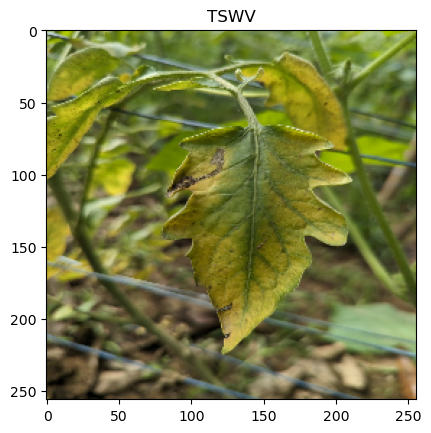

In [9]:
#visualize the first image in that batch
for image_batch, label_batch in images_dataset.take(9):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]])

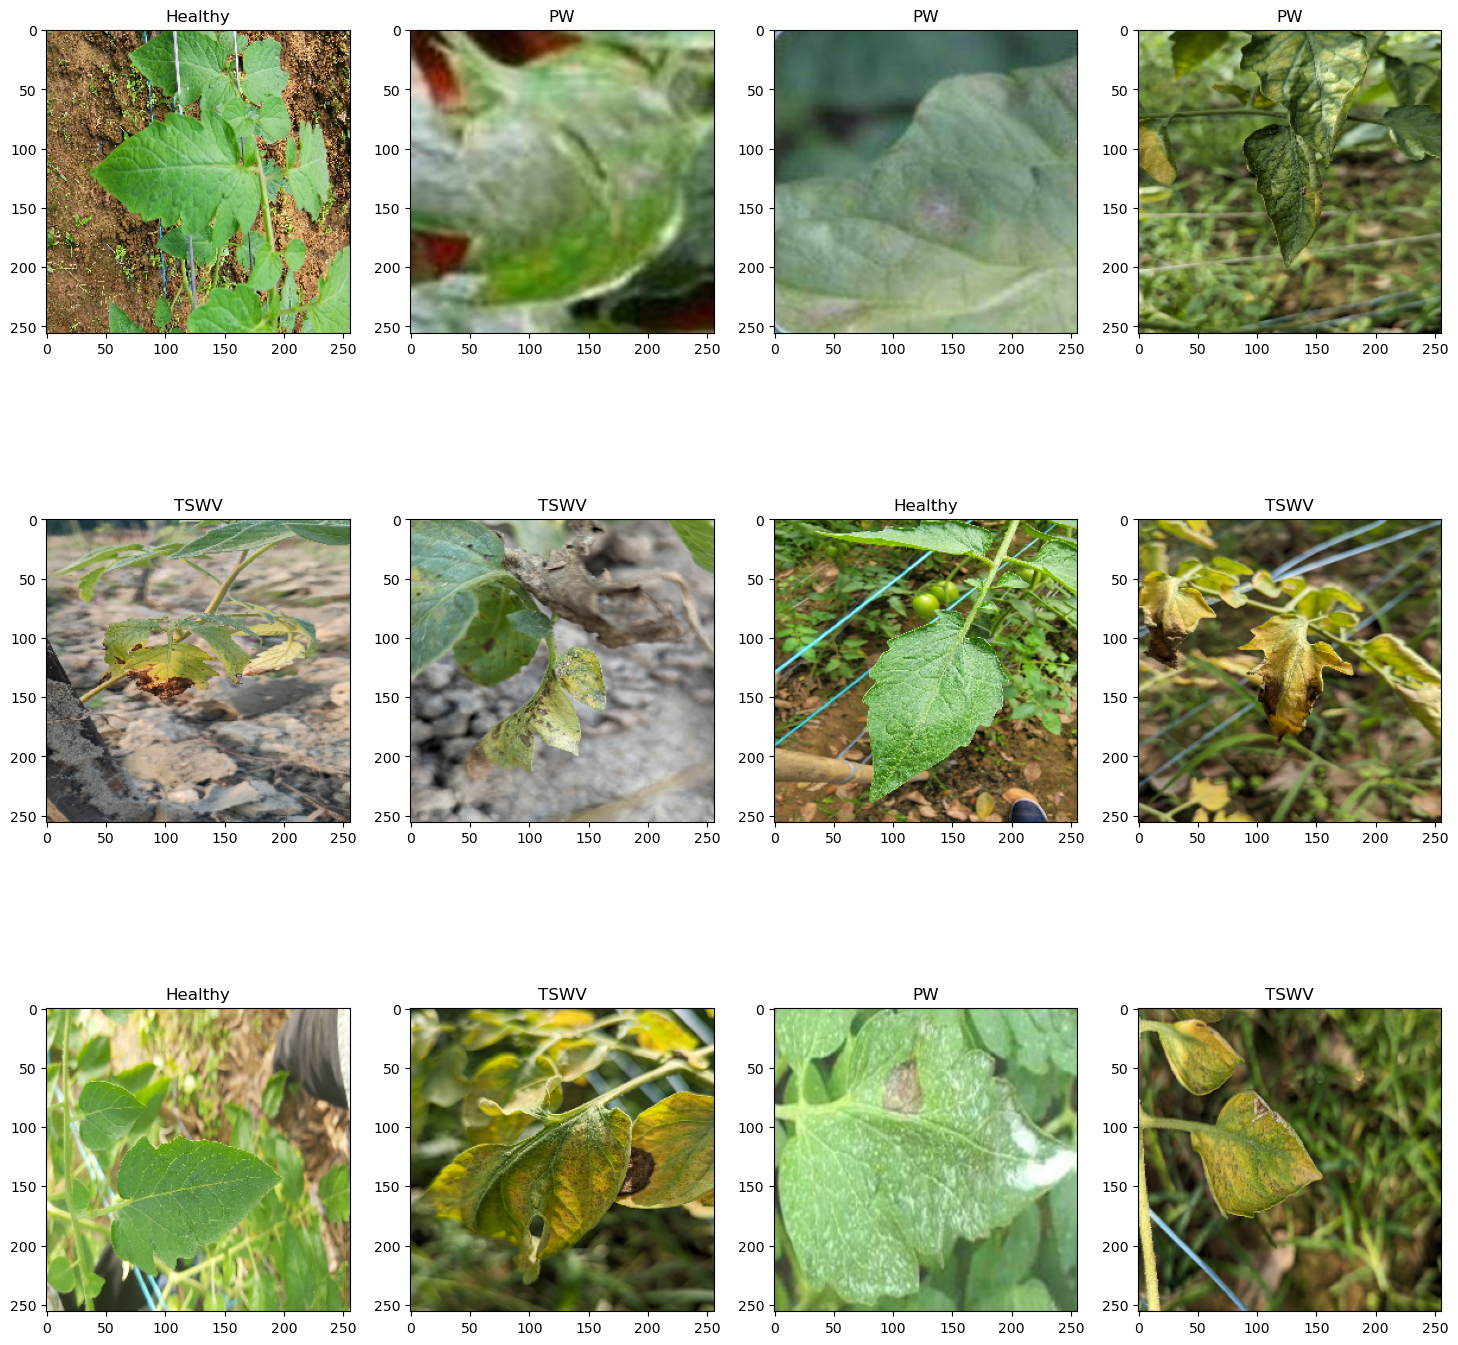

In [10]:
#visualize the first image in that batch
plt.figure(figsize=(18,18))
for image_batch, label_batch in images_dataset.take(1):
    for i in range (12):
        ax=plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])

In [11]:
len(images_dataset)

25

In [12]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size= int(train_split* ds_size)
    val_size=int(val_split* ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(images_dataset)

In [14]:
print(len(train_ds),len(val_ds),len(test_ds))

20 2 3


In [15]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [16]:
resize_and_rescale=tf.keras.Sequential([
    
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_augmentation=tf.keras.Sequential([
    
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [18]:
#building the model
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

In [19]:
#GET SUMMARY OF THE MODEL
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [20]:
#compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
#train the network with the given inputs and the corresponding labels
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


20/20 [==============================] - 51s 2s/step - loss: 0.9944 - accuracy: 0.4790 - val_loss: 0.9683 - val_accuracy: 0.5312
Epoch 2/50
20/20 [==============================] - 15s 752ms/step - loss: 0.8075 - accuracy: 0.6294 - val_loss: 0.6490 - val_accuracy: 0.6562
Epoch 3/50
20/20 [==============================] - 15s 751ms/step - loss: 0.6917 - accuracy: 0.6699 - val_loss: 0.5987 - val_accuracy: 0.6719
Epoch 4/50
20/20 [==============================] - 15s 754ms/step - loss: 0.6578 - accuracy: 0.7006 - val_loss: 0.6747 - val_accuracy: 0.6094
Epoch 5/50
20/20 [==============================] - 15s 750ms/step - loss: 0.6503 - accuracy: 0.6861 - val_loss: 0.6966 - val_accuracy: 0.7031
Epoch 6/50
20/20 [==============================] - 15s 773ms/step - loss: 0.5504 - accuracy: 0.7427 - val_loss: 0.6453 - val_accuracy: 0.7500
Epoch 7/50
20/20 [==============================] - 16s 801ms/step - loss: 0.5044 - accuracy: 0.7816 - val_loss: 0.4562 - val_accuracy: 0.7969


In [22]:
#evaluate the model
scores=model.evaluate(test_ds)

3/3 [==============================] - 15s 157ms/step - loss: 0.3135 - accuracy: 0.8646


In [23]:
scores

[0.3135245740413666, 0.8645833134651184]

In [24]:
history

In [25]:
print(history.params)

{'verbose': 1, 'epochs': 50, 'steps': 20}


In [26]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [27]:
len(history.history['accuracy'])

50

In [28]:
acc=(history.history['accuracy'])
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and validation loss')

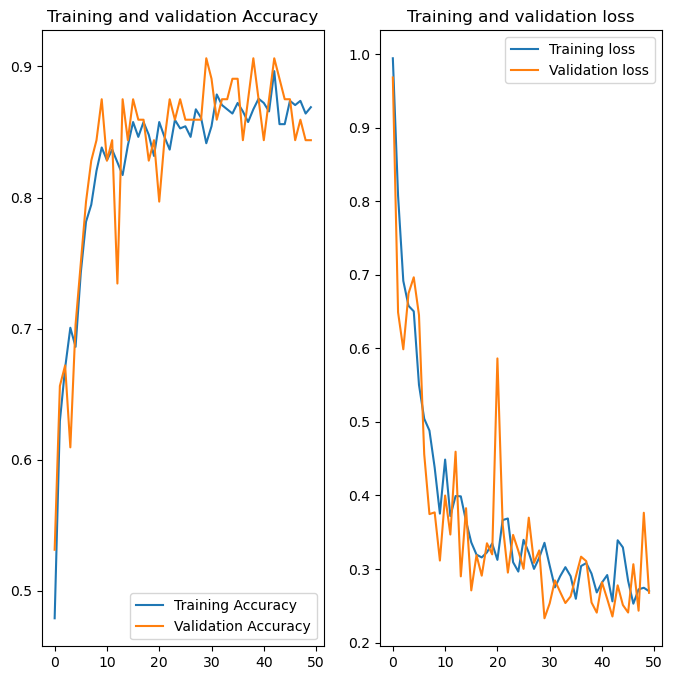

In [29]:
#plotting Accuracy and loss graph
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation Accuracy')

#ploting traning and Validation loss
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and validation loss')


Text(0.5, 1.0, 'Training and Validation Loss')

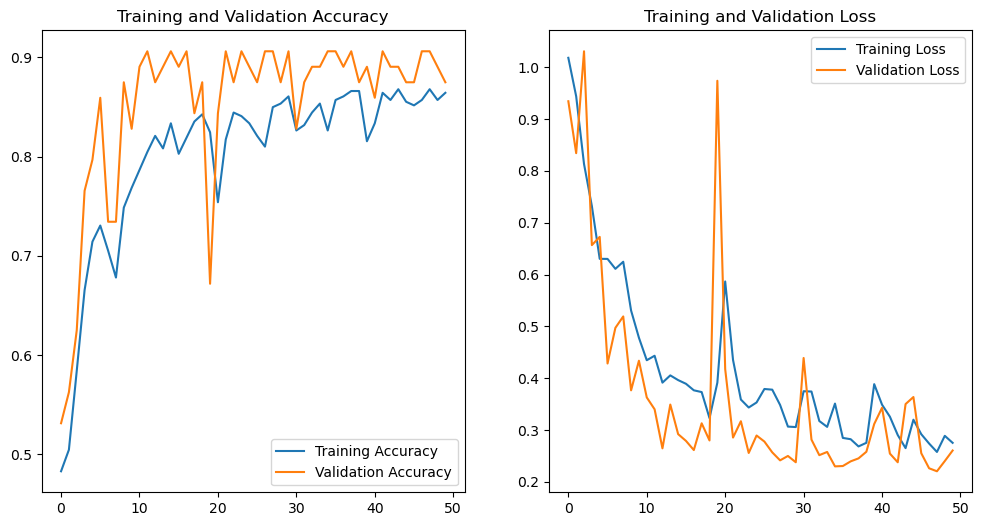

In [81]:
plt.figure(figsize=(12, 6))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


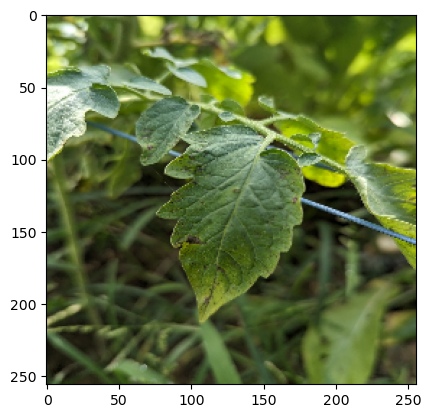

In [30]:
#making Predictions
for images_batch, label_batch in test_ds.take(1):
    plt.imshow(images_batch[0].numpy().astype('uint8'))

Predicting the first image
Image1 True Label: Healthy
1/1 [==============================] - 0s 484ms/step
Image1's predicated label: Healthy


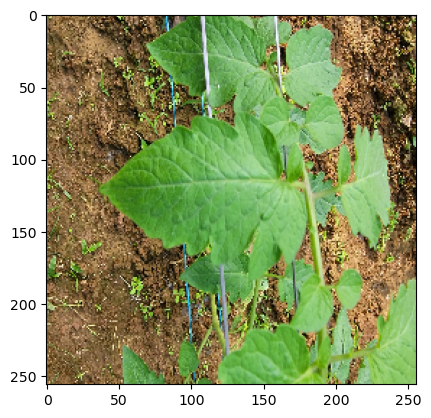

In [31]:
#making Predictions
for images_batch, label_batch in test_ds.take(1):
    image1=image_batch[0].numpy().astype('uint8')
    label1=label_batch[0].numpy()
    
    print("Predicting the first image")
    plt.imshow(image1)
    print('Image1 True Label:',class_names[label1])
    
    batch_prediction= model.predict(image_batch)
    print("Image1's predicated label:",class_names[np.argmax(batch_prediction[0])]) 

In [127]:
#function to predict with confidence
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


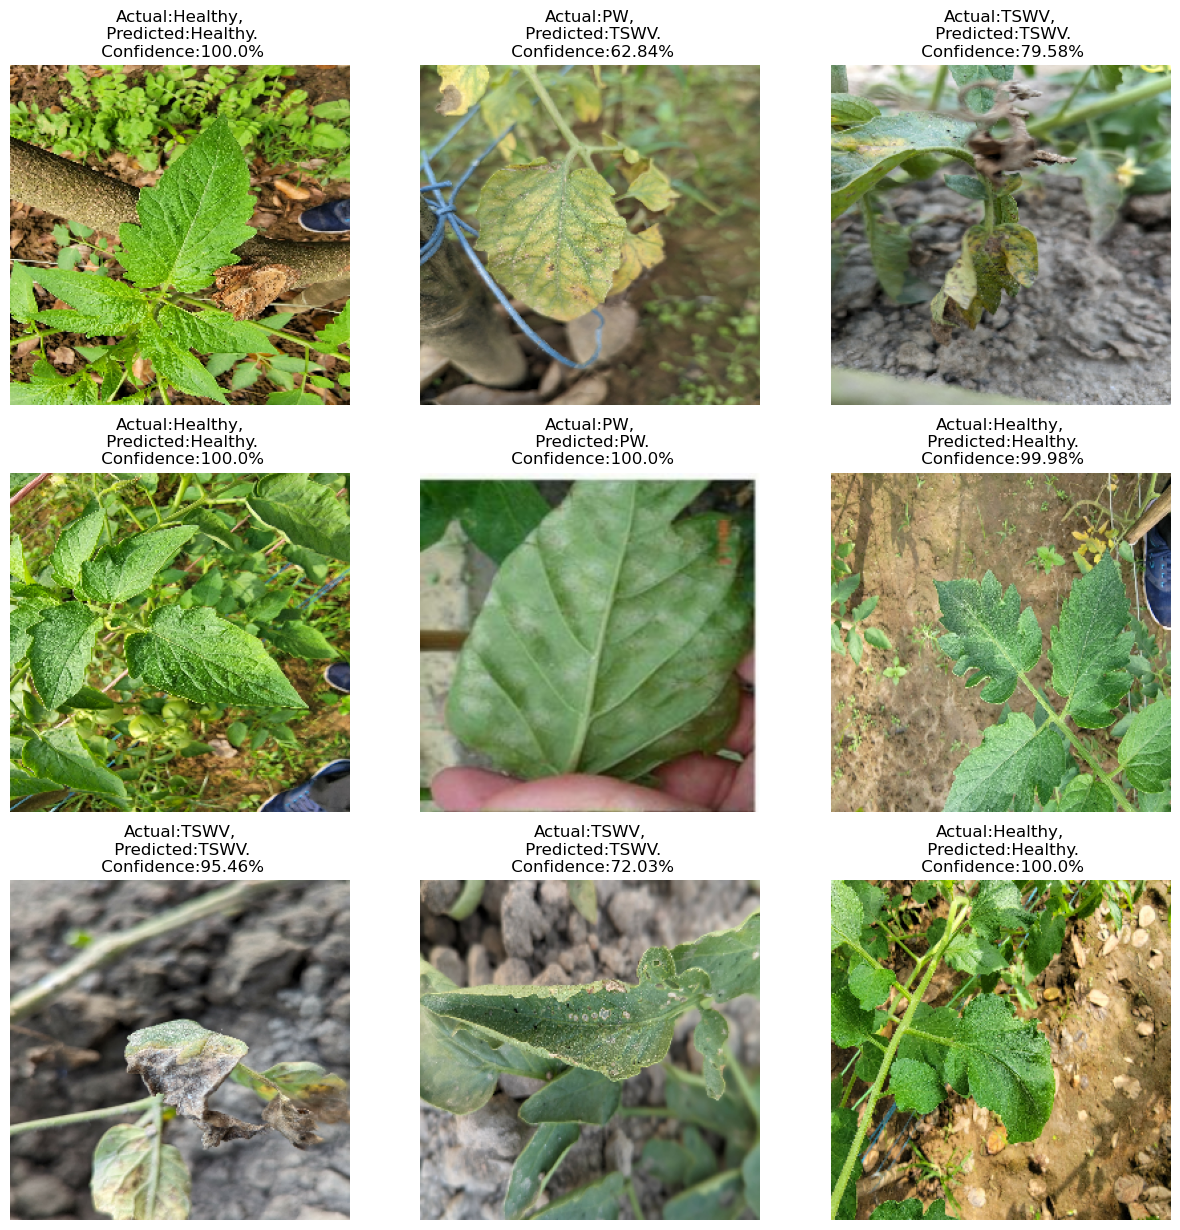

In [133]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range (9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")
        plt.axis("off")

In [136]:
model_version=1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/1\assets


INFO:tensorflow:Assets written to: ../saved_models/1\assets


In [138]:
import os 
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/2\assets


INFO:tensorflow:Assets written to: ../saved_models/2\assets


In [139]:
model.save("../tomatoes2.h5")

C:\Users\sakib\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
